In [1]:
%matplotlib inline

In [2]:
# import pickle
import pandas as pd

In [3]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [4]:
from statsmodels.distributions.empirical_distribution import ECDF

In [5]:
import pandas as pd
import numpy as np
import re

In [6]:
import itertools

In [7]:
DATA_DIR = 'state_data/'

In [23]:
print 'Reading climb dataframe pickle from ' + DATA_DIR
climb = pd.read_csv(DATA_DIR + '_climb_no_children', index_col = 0)
print "Shape of climb dataframe is", climb.shape

Reading climb dataframe pickle from state_data/
Shape of climb dataframe is (170232, 42)


In [25]:
href = '/v/pocket-rocket/106297965'
# TODO check if href in climb
href in climb.index

True

In [26]:
def scale01(feature):
    # always use on an entire column
    ecdf = ECDF(feature.dropna())
    qtile = ecdf(feature)
    scaled_feature = pd.Series(qtile, index=feature.index)
    
    # ECDF says NaN is 1.0
    scaled_feature[scaled_feature == 1.0] = float('NaN')
    
    return scaled_feature

In [27]:
def convert_hueco(hueco, LEAST_DIFFICULT=float(0), FIRST_STEP=float(1)):
    """ Takes string grade and converts it to a float """

    if not pd.isnull(hueco):
        
        # trim the prefix before the core grade
        pre = 0
        if re.search(r'^V', hueco):
            pre = 1
        elif re.search(r'^5\.', hueco):
            pre = 2
        hueco = hueco[pre:]
        
        # some special easy cases
        if hueco in ['-easy', '3rd', '4th', 'Easy 5th']:
            # lower bound
            hard = LEAST_DIFFICULT
        else:
            # V0 will be equal to this
            hard = LEAST_DIFFICULT + FIRST_STEP
            # factor in the +/- or abcd
            hard += cast_grade(hueco)
            
        return hard

In [28]:
def cast_grade(hueco):
    """ Deals with grades with endings like abcd and +/- """
    
    # abcd grades YDS grades fall here
    if re.search(r'[abcd]$', hueco):
        pnt = float(hueco.strip('abcd/'))
        adj = adj_from_letter(hueco)
        rate = pnt + adj
    
    # anything ending in +/-
    elif re.search(r'(\+$)|(-$)', hueco):
        pnt = float(hueco[:-1].strip())
        # add/take a half a point off for plus minus
        if hueco[-1] == '+':
            rate = pnt + .5
        else:
            rate = pnt - .5
    
    # hueco ratings often have a range like V3-4
    elif re.search(r'(\d+)[- ]+(\d+)', hueco):
        # return the mean of range
        lower = re.findall(r'\d+', hueco)[0].strip()
        upper = re.findall(r'\d+', hueco)[1].strip()
        rate = np.mean( [float(lower), float(upper)] )
    
    # if we can find any number cast as float ignoring sign
    elif re.search(r'\d+', hueco):
        try:
            core_rate = float(hueco.strip('+-/'))
        except:
            rate = None
        else:
            rate = core_rate
    
    # else nothing recognizable
    else:
        rate = None
        
    return rate

In [29]:
def adj_from_letter(grade):
    letter_jumble = re.sub('[\W\d_]+', '', grade)
    adj = []
    for letter in letter_jumble:
        if letter == 'a':
            adj.append(-.5)
        elif letter == 'b':
            adj.append(-.25)
        elif letter == 'c':
            adj.append(+.25)
        elif letter == 'd':
            adj.append(+.5)
            
    # mean not sum beacuse b/c is easier than c
    return np.mean(adj)

In [30]:
def combine_grade(climb):
    """ Allows mixing of Bouldering and Sport/Trad routes """
    climb['floatHueco'] = map(convert_hueco, climb['rateHueco'])
    climb['pctHueco'] = scale01(climb['floatHueco'])

    climb['floatYDS'] = map(convert_hueco, climb['rateYDS'])
    climb['pctYDS'] = scale01(climb['floatYDS'])

    # might prefer the YDS-esque rating if there is one
    # not many conflicting cases -- max is reasonable assuption
    climb['gradeComb'] = climb[['pctHueco','pctYDS']].max(axis='columns')
    
    return climb['gradeComb']

In [31]:
# TODO graph cumsum percentile of climbing difficulty and YDS

In [32]:
def score(grade, ideal):
    return 1 - abs(ideal - grade)

In [33]:
def castscale(feature_name, climb, href, diff = True):
    casted = climb[feature_name].astype(float)
    scaled = scale01(casted)
    ideal = scaled.loc[href]
    
    if diff:
        scored = map(score, scaled, itertools.repeat(ideal, len(casted)))
        recco = pd.Series(scored, index=climb.index)
    else:
        recco = pd.Series(scaled, index=climb.index)
    return recco

In [34]:
# preprocessing of grades
climb['gradeComb'] = combine_grade(climb)

In [36]:
def combine_text(jess):
        
    # TODO do this with a map
    txt_collect = []
    for txt in ['description', 'other_text']:
        if hasattr(jess, txt):
            if not pd.isnull(jess[txt]):
                txt_collect.append(jess[txt])

    return "\n".join(txt_collect)

def get_total_climb_description(climb):
    collect = []
    for href, cmb in climb.iterrows():
        cmbtxt = combine_text(cmb)
        collect.append(cmbtxt)

    print "Preprocessed %d text segments" % len(collect)

    return collect

In [37]:
descriptive = get_total_climb_description(climb)

Preprocessed 170232 text segments


In [38]:
tfidf = TfidfVectorizer(
    decode_error='ignore', stop_words='english',
    sublinear_tf=True, ngram_range=(1, 2))
svd = TruncatedSVD(
    n_components=100, random_state=42)

In [39]:
TFIDF = tfidf.fit_transform(descriptive)

In [40]:
shrunk = svd.fit_transform(TFIDF)

In [41]:
shrunk.shape

(170232, 100)

In [42]:
pos = climb.index == href
sim = cosine_similarity(shrunk[pos], shrunk)
sim_score = pd.Series(sim[0], index=climb.index)

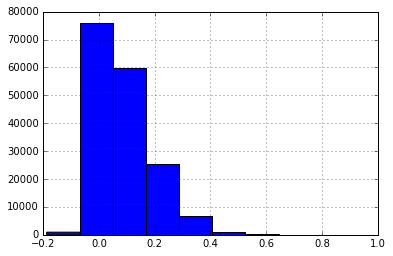

In [43]:
sim_score.hist()

In [44]:
def score_boolean(grade, ideal):
    return grade * ideal

In [45]:
climb.columns

Index([u'aid', u'alpine', u'area_hierarchy', u'boulder', u'children_href',
       u'chipped', u'commitment', u'description', u'elevation', u'fa', u'feet',
       u'getting_there', u'href', u'ice', u'is_area', u'is_route', u'location',
       u'mixed', u'name', u'nickname', u'other_text', u'page_views',
       u'pitches', u'protect_rate', u'protection', u'rateBritish',
       u'rateEwbanks', u'rateFont', u'rateFrench', u'rateHueco', u'rateUIAA',
       u'rateYDS', u'rateZA', u'season', u'sport', u'staraverage', u'starbest',
       u'starvotes', u'submitted_by', u'tr', u'trad', u'type', u'floatHueco',
       u'pctHueco', u'floatYDS', u'pctYDS', u'gradeComb'],
      dtype='object')

In [46]:
def match_type(climb, href):
    """ Give scores for climbs that match bouldering, sport, trad, etc."""
    
    # these columns are True or NaN
    type_of_route = { 'aid': 1, 'alpine': 1, 'boulder': 1, 'sport': 1, 'trad': 1 , 'ice': 1 }
    
    collect = []
    for k, v in type_of_route.items():

        # turn boolean into value of 1
        scaled = pd.notnull(climb[k]).astype(int)
        ideal = climb.loc[href][k]

        # score destinations relative to ideal
        scored = map(score_boolean, scaled, itertools.repeat(ideal, len(scaled)))
        weighted = pd.Series(np.multiply(scored, v), index=climb.index)

        collect.append(weighted)

    # combine dimensions into one score
    all_type_score = pd.concat(collect, axis = 1)
    type_score = all_type_score.sum(axis='columns')
    return type_score / max(type_score)

In [47]:
type_score = match_type(climb, href)

In [35]:
# score columns!
height_score = castscale('feet', climb, href)
grade_score = castscale('gradeComb', climb, href)
star_score = castscale('staraverage', climb, href, False)
vote_score = castscale('starvotes', climb, href, False)

In [52]:
# aggregate scores
charlie = pd.DataFrame({
        'height': height_score,
        'grade': grade_score,
        'stars': star_score,
        'votes': vote_score,
        'sim': sim_score,
        'type': type_score
    })

# multiply weights
charlie['sim'] = charlie['sim'] * 25
charlie['grade'] = charlie['grade'] * 15
charlie['height'] = charlie['height'] * 5
charlie['stars'] = charlie['stars'] * 15
charlie['votes'] = charlie['votes'] * 5
charlie['type'] = charlie['type'] * 10


charlie['best'] = charlie.sum(axis='columns')
charlie.sort_values('best', ascending=False, inplace=True)


In [54]:
recco_href = charlie.index[:10]
climb.loc[recco_href][['rateYDS','rateHueco','staraverage','votes','description']]

,name,rateYDS,rateHueco,staraverage,description
/v/pocket-rocket/106297965,Pocket Rocket,5.10c,NaN,3.3,The route starts with harder moves through an ...
/v/monsoon/107015696,Monsoon,5.10c,NaN,3.6,"Bring the rain, bring the pain. This is anothe..."
/v/k-6/105938903,K-6,5.11b,NaN,3.5,Another classic 11b up an intimidating overhan...
/v/king-kong/106099195,King Kong,5.11a,NaN,3.2,The route starts off with blocky climbing on b...
/v/sunshine-buttress/107127972,Sunshine Buttress,5.10a,NaN,3.2,This long route has some varied climbing and e...
/v/catacomb/106806898,Catacomb,5.10c,NaN,3.0,Right arcing route. Starts with tricky slab cl...
/v/store/107388644,Store,5.10c,NaN,3.7,Solid route for the grade. Start up near the a...
/v/alobeitor/107492711,Alobeitor,5.10-,NaN,3.2,"A slightly overhyped route, but still good fun..."
/v/international-distress/107191068,International Distress,5.11b,NaN,3.4,"Perfect pockets, the quintessential Spearfish ..."
/v/sadako/107714052,Sadako,5.11b,NaN,3.0,"Excellent variety on this pumpfest! Flakes, cr..."
